In [1]:
import MDAnalysis as mda
from MDAnalysis.auxiliary import EDR
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.align as align
import MDAnalysis.analysis.diffusionmap as diffusionmap

#Widgets
import ipywidgets as widgets
from ipywidgets import Box

from modules import *

#Math
import numpy as np

# Import viewer
import nglview

import matplotlib.pyplot as plt

#other general things
import warnings
import os

%reload_ext autoreload
%autoreload 2



## Inputs

### Inputs files and options
run the 2 below cells first to select option, and then run the rest

In [2]:
align_traj = widgets.Checkbox(value=True, description='Align Trajectory',disabled=False,indent=False)
radius_of_gyration = widgets.Checkbox(value=False,description='Calculate Radius of Gyration',disabled=False,indent=False)
calculate_RMSD = widgets.Checkbox(value=False, description='Calculate RMSD',disabled=False,indent=False)
calculate_RMSF = widgets.Checkbox(value=False,description='Calculate RMSF',disabled=False,indent=False)
pairwise_RMSD =  widgets.Checkbox(value=False,description='Calculate Pairwise RMSD',disabled=False,indent=False)
optionbox = Box(children=[align_traj,radius_of_gyration,calculate_RMSD,calculate_RMSF,pairwise_RMSD])
optionbox


Box(children=(Checkbox(value=True, description='Align Trajectory', indent=False), Checkbox(value=False, descri…

In [3]:
edr_only =  widgets.Checkbox(value=False,description='only run EDR analysys',disabled=False,indent=False)
EDRbox = Box(children=[edr_only])
EDRbox

Box(children=(Checkbox(value=False, description='only run EDR analysys', indent=False),))

In [6]:
### Needed input
sim_path = "D:\\MD\\Cr2RBM-2\\"
ligand_name = None #set to None if no ligand
coordinate_file_name = 'md250ns_po_start.pdb'             ##tpr or gro file tpr needed for h bond
trajectory_file_name = 'md250ns_center_po.xtc'      ##xtc file
auxiliary_file_name = 'md250ns.edr'              ##edr file
reference_structure_path = 'md1ns.gro'

sim_name = 'default' ##output pdb file will use thise name, if set to "default" will use the auxilliary file name

#Options
#RMSD_groups = ["284 to 400" , "400 to 426" ]
#RMSD_groups_name = ["Core" , "C-term" ]
RMSD_groups = ["1 to 92"]
RMSD_groups_name = ["all"]
H_bonds = False
start_frame = 100
stop_frame = None



if sim_name == 'default':
    sim_name = auxiliary_file_name.split(".")[0]

RMSD_groups_name.insert(0, "Overall")

if edr_only.value:
    align_traj = None
    radius_of_gyration = None
    calculate_RMSD = None
    calculate_RMSF = None
    pairwise_RMSD =  None


### Reading and preprocessing

In [7]:
## Read the diferents files
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not edr_only.value:
        reference_structure = mda.Universe(sim_path + reference_structure_path,)
        if os.path.isfile(sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc"): ## read the aligned file if it exist
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
            print("Aligned file found, reading this instead")
            is_aligned = True
        else:
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
            is_aligned = False
    energy_like_terms = EDR.EDRReader(sim_path + auxiliary_file_name)


In [ ]:
if align_traj.value:
    if not is_aligned:
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
        do_trajectory_CAalignement(atomistic_system, sim_path, trajectory_file_name)
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
    else:
        print(f"Trajectory allready aligned, delete {trajectory_file_name.split('.')[0] + '_aligned.xtc'} to rerun alignement")

Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement


## Sanity Check
Check that simulation isn't going wrong, read temperature and pressure through the EDR <br>
list of the available data can be obtained with: <br>


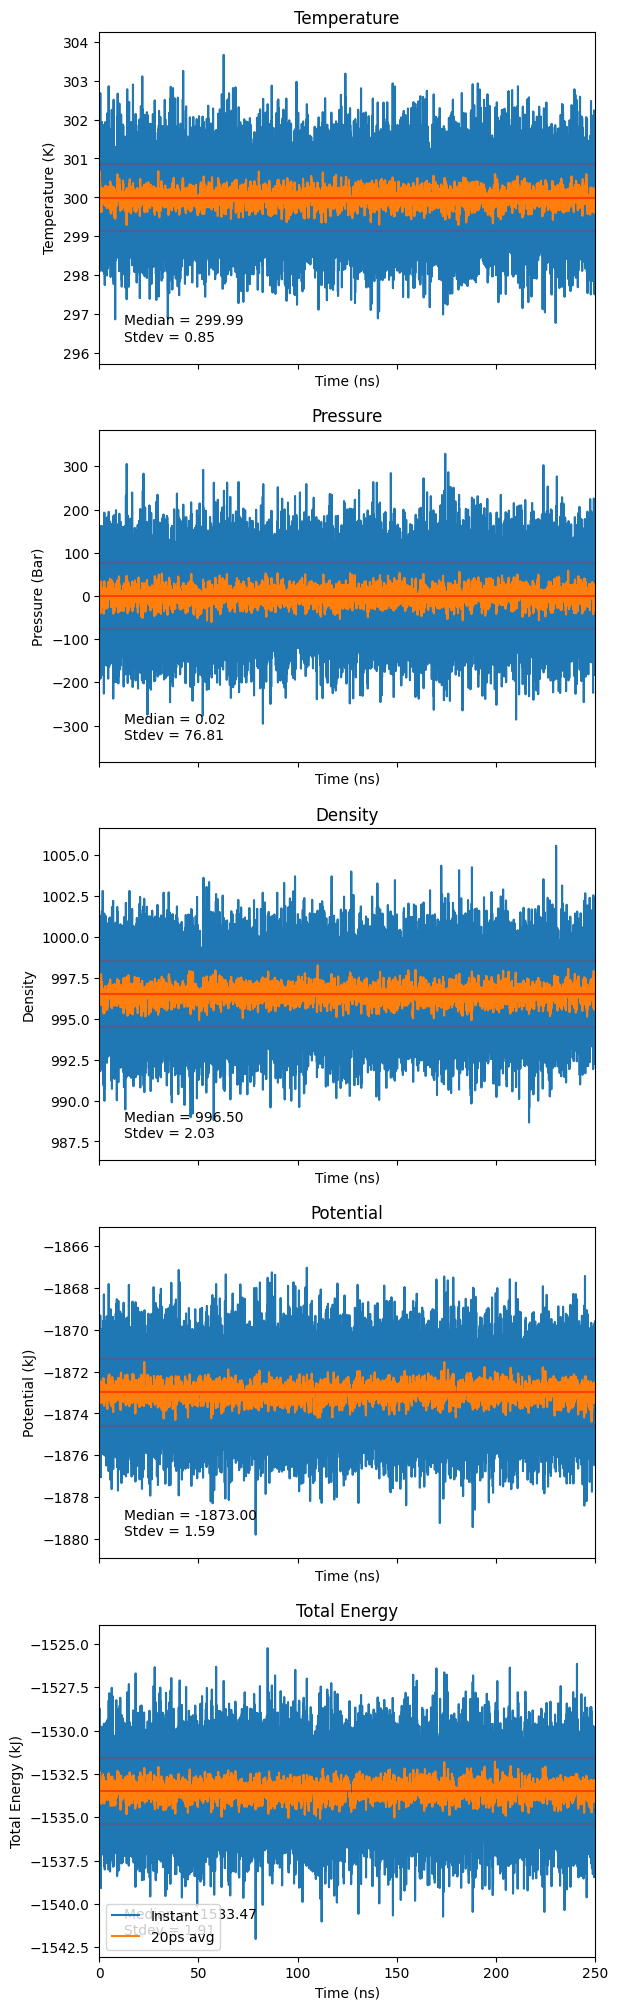

In [ ]:
fig, axs = plt.subplots(5, sharex=True)
fig.set(figheight=25)
edr_plot(energy_like_terms, axs[0],'Temperature', "K", edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[1],'Pressure', "Bar", edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[2],'Density', edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[3],'Potential', "kJ", divide = 1000, edr_only=edr_only.value)
edr_plot(energy_like_terms, axs[4],'Total Energy', "kJ", divide = 1000, edr_only=edr_only.value)
plt.legend()


### Box size

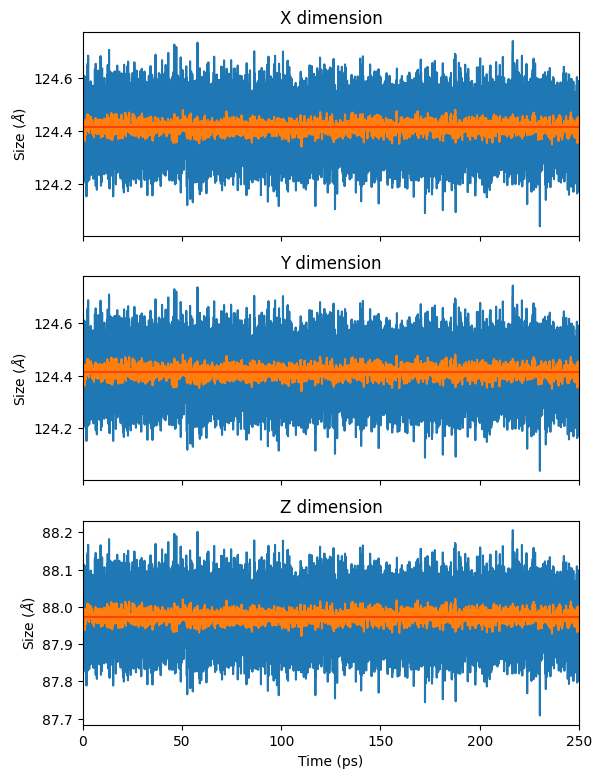

In [ ]:
#Get and plot Density data
box_plot(energy_like_terms)


## View the simulation

In [ ]:
# Open an NGLView widget
view = nglview.show_mdanalysis(atomistic_system, default_representation=False)
# Add the atomistic system to the widget
view.add_representation('cartoon', selection='protein')

#view.add_representation('licorice', selection='water')

# Add spacefill representtaion for the ions (Potassium, Chloride)
view.add_representation('spacefill', selection='.POT .CLA', opacity=0.5)


# Center the view
if ligand_name:
    try:
        test = atomistic_system.select_atoms(f"resname {ligand_name}")[0] # crash if ligand name corespond to nothing
        view.center(ligand_name)
        view.add_representation('licorice', selection= ligand_name )
    except:
        view.center('protein')
else:
    view.center('protein')

# Set the view to orthographic
view.camera = 'orthographic'

# Show the view in the widget
view

NGLWidget(max_frame=25000)

## Analysis

### Radius of gyration

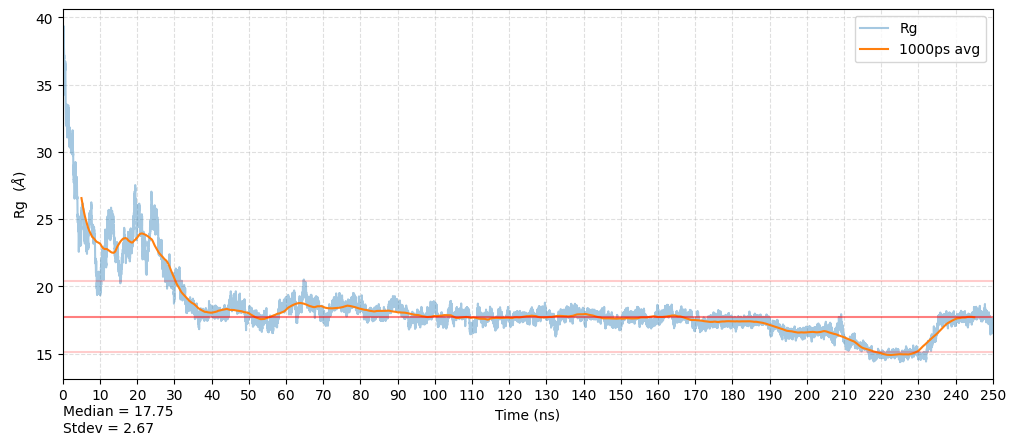

In [27]:
#@title <b><font color='#45B69C'>3.1 - Run MD simulation</font></b>
#@markdown Simulation time (ns):
Simulation_time = "AUTO" #@param {type:"raw"}

if radius_of_gyration.value:
    Rgyr = Rg(atomistic_system)

In [18]:
if radius_of_gyration.value:
    distances_3Darray = calculate_3D_distance(atomistic_system)

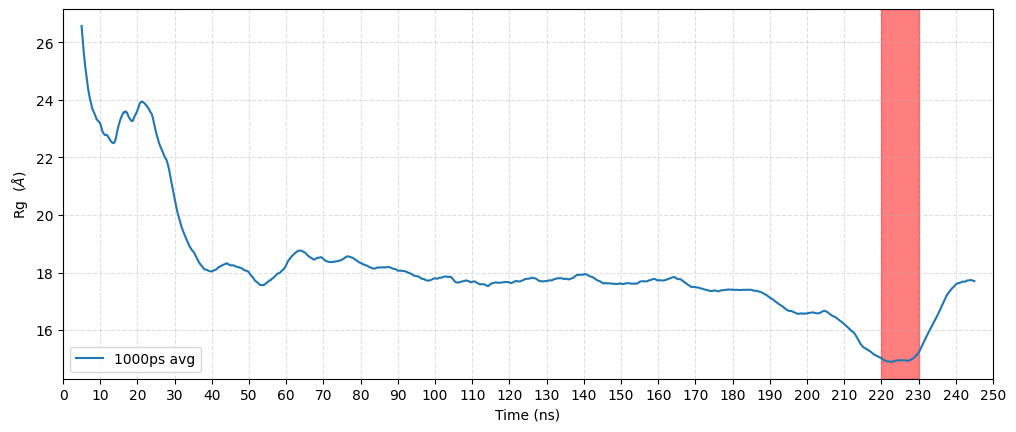

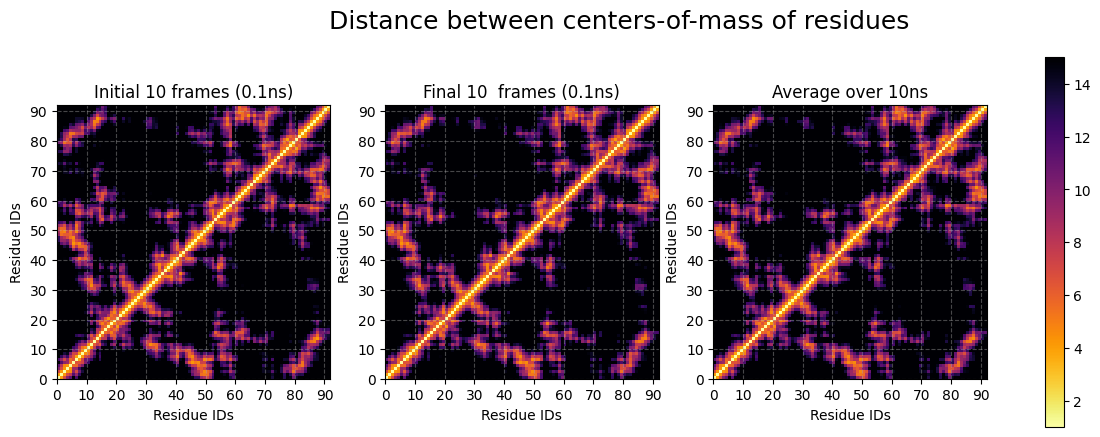

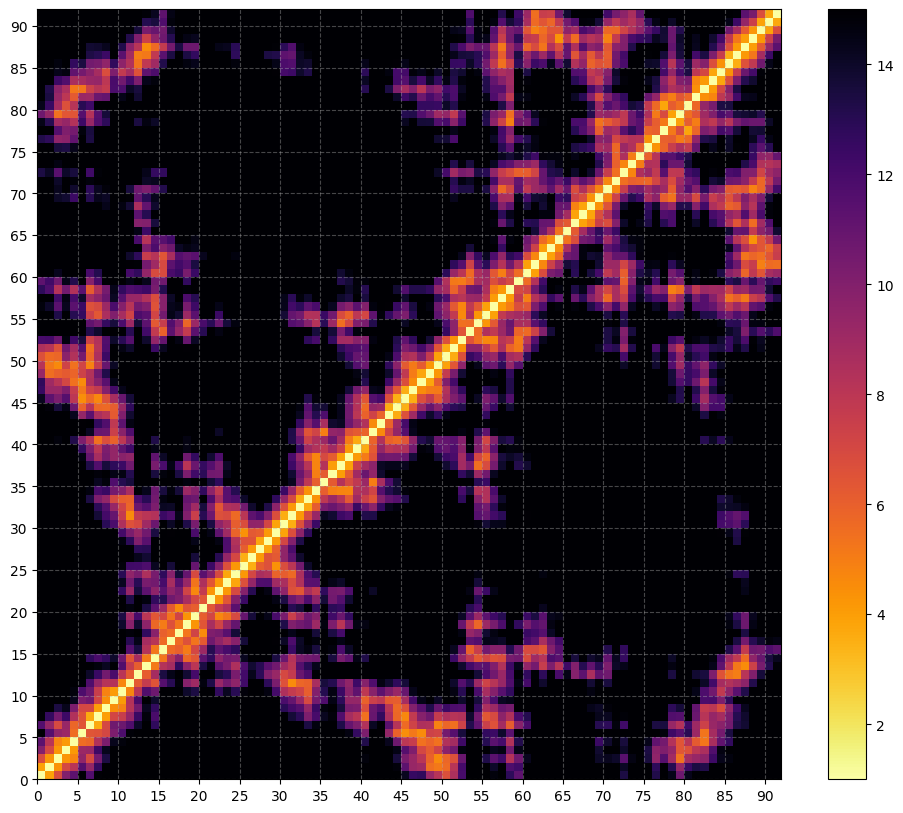

In [30]:
dist_max = 15
contact_start = 220
contact_finish = 230

if radius_of_gyration.value:
    plot_distances(Rgyr, distances_3Darray, contact_start, contact_finish, dist_max)
    
    ## Extras
    plot_distances_HD(distances_3Darray, contact_start, contact_finish, dist_max)
    mean = np.mean(distances_3Darray[contact_start *100 : contact_finish *100], axis=0)
    np.savetxt(f"{sim_path}distances_avg_{contact_start}ns-{contact_finish}ns.csv", mean, delimiter="," )

### RMSD
Measure RMS deviation from the original structure during the simulation time


In [ ]:
if calculate_RMSD.value:
    grouplist =[]
    for group in RMSD_groups:
        grouplist.append(f"protein and name CA and resid {group}")

    # Calculate RMSD using the MDAnalysis functionality
    ref_structure = reference_structure

    # Input: simulation trajectory, reference structure, atoms to superimpose, atoms to calculate the RMSD for
    RMSD = rms.RMSD(atomistic_system,      # Trajectory
                    ref_structure,         # Reference structure
                    select="protein and name CA",   #residus selection for superimposition     
                    groupselections = grouplist)  # RMSD groups
    # Run RMSD analysis
    RMSD.run(verbose=True)

In [ ]:
if calculate_RMSD.value:
    #Option to start the plot at specific time (cut of first ms of equilibration)
    plot_0 = 0
    # Extract data for plotting
    rmsd = RMSD.results.rmsd.T  #T = transpose
    # Extract the time data from the RMSD output. Divide by 1000 to get time in ns
    time = rmsd[1]/1000
    
    plot_RMSD(rmsd, time, RMSD_groups, RMSD_groups_name, plot_0)

### Pairwise RMSD

In [ ]:
if pairwise_RMSD.value:
    aligner = align.AlignTraj(atomistic_system, atomistic_system, select='name CA',in_memory=False,filename="tmp.xtc")
    aligner.run(verbose=True)

    aligned_atomistic_system = mda.Universe(sim_path + coordinate_file_name,"tmp.xtc")
    matrix = diffusionmap.DistanceMatrix(aligned_atomistic_system, select='name CA')
    matrix.run(verbose=True)
    print(matrix.results.dist_matrix.shape)

In [ ]:
if pairwise_RMSD.value:
    plt.imshow(matrix.dist_matrix, cmap='viridis')
    plt.xlabel('Frame')
    plt.ylabel('Frame')
    plt.colorbar(label=r'RMSD ($\AA$)')



### RMSF
Calculate RMS fluctuation per residues from an <b>average structure</b>.

In [ ]:
# Generate an average structure
if calculate_RMSF.value:
    
    if not is_aligned:
        do_trajectory_CAalignement(atomistic_system, sim_path, trajectory_file_name)
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
     
#Run RMSF analysis
    C_alphas = atomistic_system.select_atoms('protein and name CA')
    print("Run RMSF calculation")
    RMSF = rms.RMSF(C_alphas)
    RMSF.run(verbose=True)

In [ ]:
if calculate_RMSF.value:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(C_alphas.resids, RMSF.results.rmsf, label='RMSF')
    # Add axis labels
    ax.set_xlabel('Residue number')
    ax.set_ylabel('RMSF  ($\AA$)')

    # Set axis limits
    ax.set_xlim(C_alphas.resids[0], C_alphas.resids[-1] )
    ax.set_ylim(min(RMSF.results.rmsf))

    # plt median and + 1 stdev
    plt_median(ax, RMSF.results.rmsf, negative=False, label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

In [ ]:
if calculate_RMSF.value:
    # dynamically add new attributes
    # ('tempfactors' is pre-defined and filled with zeros as default values)
    atomistic_system.add_TopologyAttr('tempfactors')
    C_alphas.tempfactors = RMSF.results.rmsf


#write PDB file with RMS as B factore
    if ligand_name:
        write_group = atomistic_system.select_atoms(f"(protein and name CA) or resname {ligand_name}")
    else:
        write_group = C_alphas

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        write_group.write(sim_path + sim_name +  "_RMSF.pdb")


## H-Bonds

In [ ]:
hbonds = False
if H_bonds and ligand_name:
    from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
    hbonds = HBA(universe=atomistic_system, between=["protein", f"resname {ligand_name}"])

# Guess H and accepetors
    protein_H = hbonds.guess_hydrogens("protein")
    protein_acc = hbonds.guess_acceptors("protein")
    ligand_H = hbonds.guess_hydrogens(f"resname  {ligand_name}")
    ligand_acc =  hbonds.guess_acceptors(f"resname {ligand_name}")

    hbonds.hydrogens_sel = f"({protein_H}) or ({ligand_H})"
    hbonds.acceptors_sel = f"({protein_acc}) or ({ligand_acc})"

    hbonds.run(verbose=True, start=start_frame, stop=stop_frame)

In [ ]:
if hbonds:
    print(hbonds.results.hbonds.shape)

    plt.plot(hbonds.times, hbonds.count_by_time(), lw=2)

    plt.title("Number of hydrogon bonds over time", weight="bold")
    plt.xlabel("Time (ps)")
    plt.ylabel(r"$N_{HB}$")

    plt.show()

In [ ]:
if hbonds:
    for donor, acceptor, count in hbonds.count_by_type():

        donor_resname, donor_type = donor.split(":")
        n_donors = atomistic_system.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms

        # average number of hbonds per donor molecule per frame
        mean_count = 2 * int(count) / (hbonds.n_frames * n_donors)  # multiply by two as each hydrogen bond involves two water molecules
        print(f"{donor} to {acceptor}: {mean_count:.2f}")